Model Classes: {0: 'animal', 1: 'civilian', 2: 'civilian vehicle', 3: 'military vehicle', 4: 'solider', 5: 'weapon'}
Image loaded successfully: (280, 390, 3)

0: 480x640 1 civilian, 2 soliders, 89.9ms
Speed: 1.3ms preprocess, 89.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

Total detections: 3
Detected: civilian (class 1) with confidence 0.78
Detected: solider (class 4) with confidence 0.72
Detected: solider (class 4) with confidence 0.62

DETECTION SUMMARY
Civilians detected: 1
Soldiers detected: 2
Weapons detected: 0
Civilian Vehicles detected: 0
Military Vehicles detected: 0

Checking: Civilian + Weapon combinations...

Checking: Civilian Vehicle + Weapon combinations...

✅ NO SUSPICIOUS ACTIVITY DETECTED

Displaying detection result...


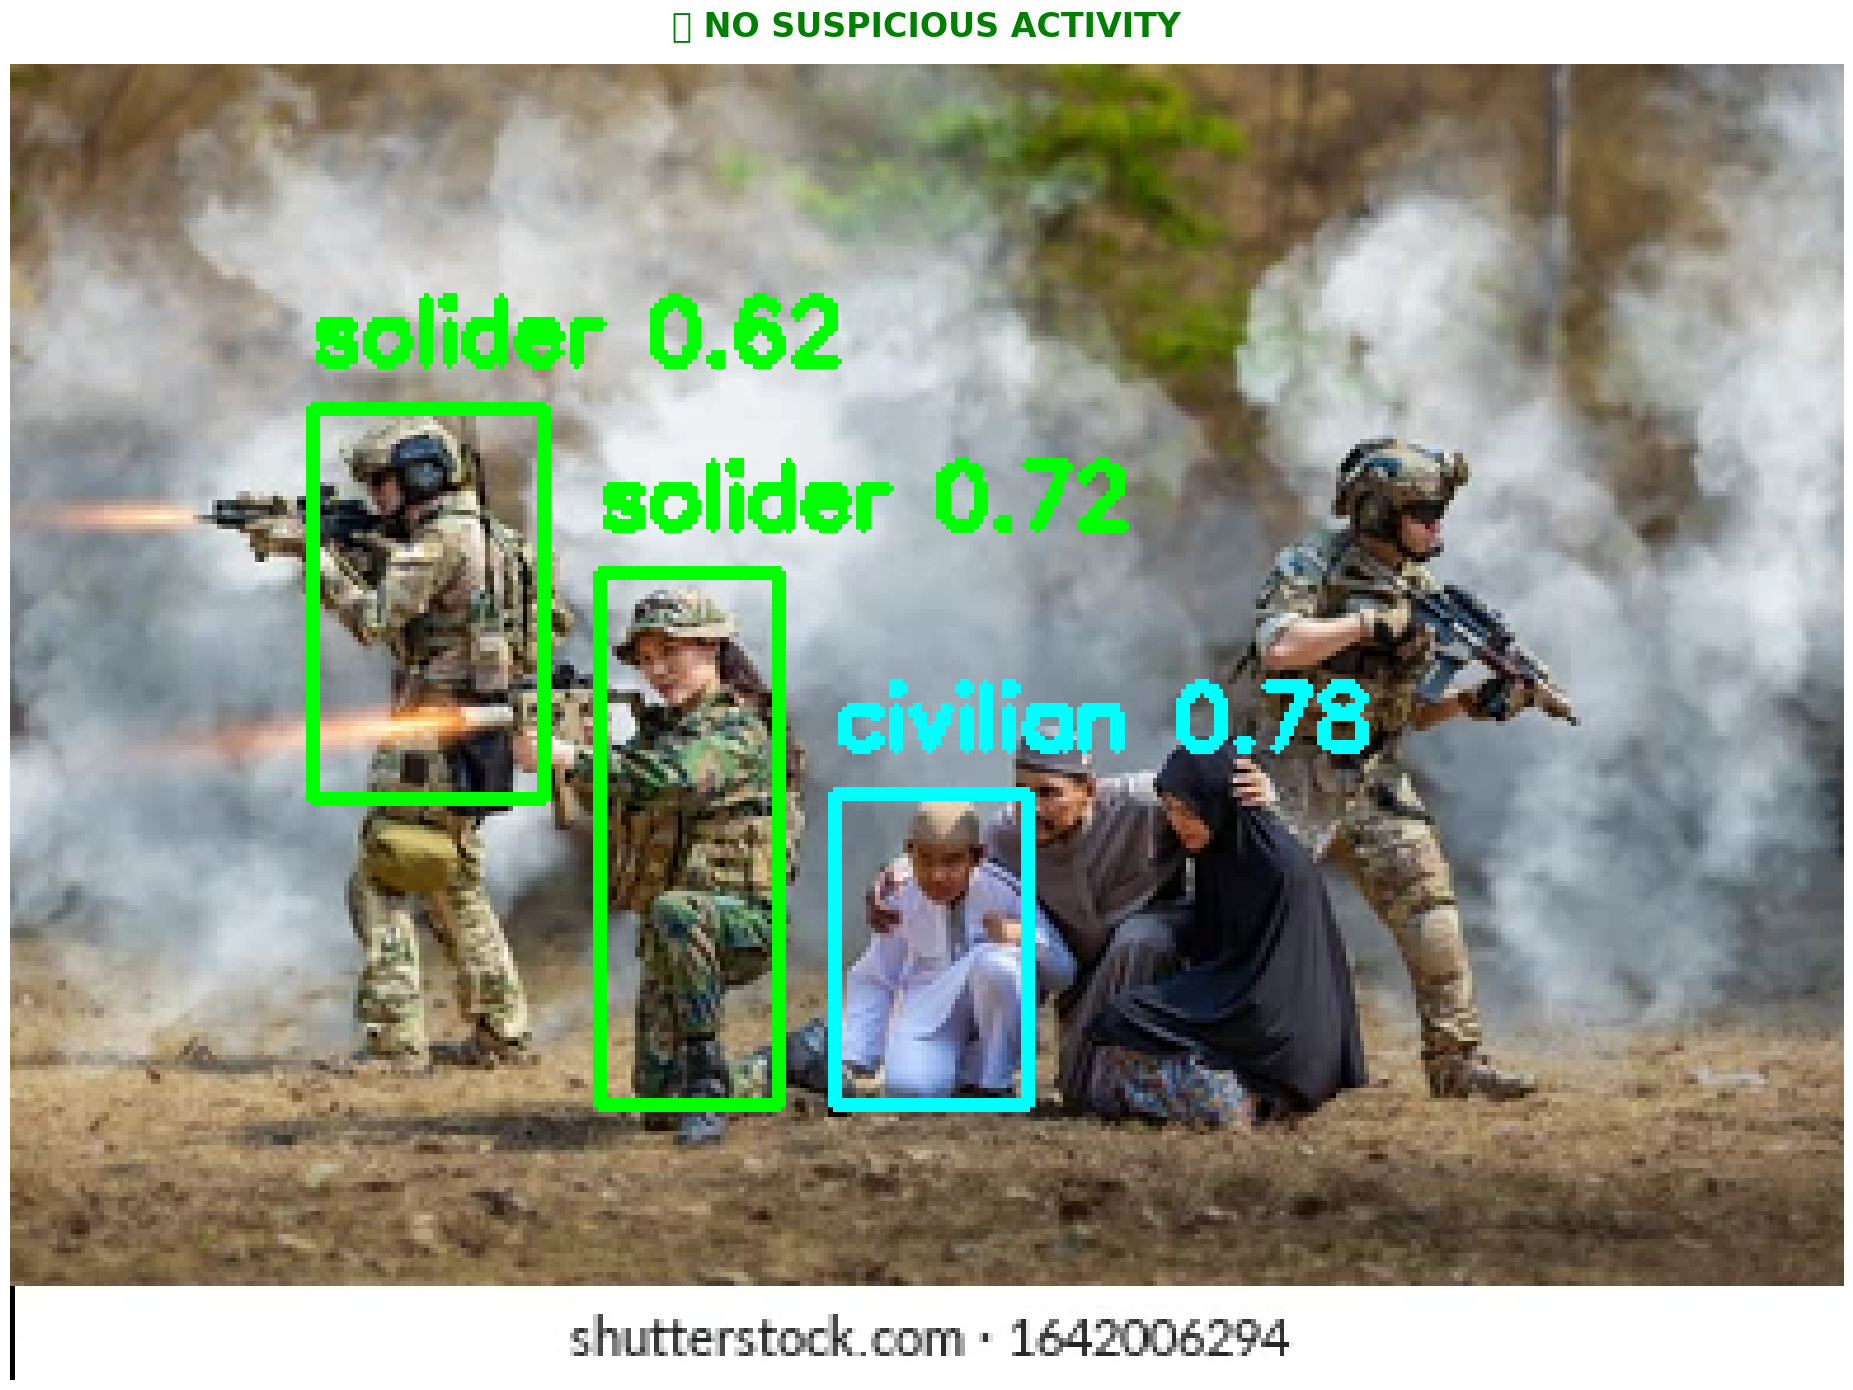


✓ Image displayed above ↑

✓ Result saved to: detection_result.jpg

DETECTION LOGIC
SUSPICIOUS (Alert Triggered):
  • Civilian + Weapon (weapon not near any soldier)
  • Civilian Vehicle + Weapon (weapon not near any soldier)

NOT SUSPICIOUS:
  • Soldier + Weapon (authorized)
  • Civilian without weapon
  • Weapon near soldier in/near vehicle


In [4]:
from ultralytics import YOLO
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# Enable inline plotting for Jupyter
%matplotlib inline

# Load your custom YOLO model
model = YOLO('C:/Users/kolig/Downloads/test/my_model/my_model.pt')
class_names = model.names

print("Model Classes:", class_names)

# Load image
img_path = 'C:/Users/kolig/Downloads/test/my_model/test8.jpg'
frame = cv2.imread(img_path)

if frame is None:
    print("Error: Could not load image!")
    exit()
else:
    print(f"Image loaded successfully: {frame.shape}")

# Run detection
results = model(frame, conf=0.5)[0]

# Store detections by class
civilians = []
soldiers = []
weapons = []
civilian_vehicles = []
military_vehicles = []

print(f"\nTotal detections: {len(results.boxes.data.tolist())}")

# Parse detections
for det in results.boxes.data.tolist():
    x1, y1, x2, y2, conf, cls_id = det
    cls_id = int(cls_id)
    label = class_names[cls_id]
    
    print(f"Detected: {label} (class {cls_id}) with confidence {conf:.2f}")
    
    # Categorize detections (matching exact model class names)
    if label == 'civilian':
        civilians.append((x1, y1, x2, y2, label, conf))
        color = (255, 255, 0)  # Yellow
    elif label == 'solider':  # Note: model has typo 'solider' not 'soldier'
        soldiers.append((x1, y1, x2, y2, label, conf))
        color = (0, 255, 0)  # Green
    elif label == 'weapon':
        weapons.append((x1, y1, x2, y2, label, conf))
        color = (0, 0, 255)  # Red
    elif label == 'civilian vehicle':  # Note: model has space not underscore
        civilian_vehicles.append((x1, y1, x2, y2, label, conf))
        color = (255, 165, 0)  # Orange
    elif label == 'military vehicle':
        military_vehicles.append((x1, y1, x2, y2, label, conf))
        color = (0, 128, 255)  # Blue
    else:
        color = (255, 255, 255)  # White for other classes
    
    # Draw all detections
    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
    cv2.putText(frame, f"{label} {conf:.2f}", (int(x1), int(y1)-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Function to check if two boxes are nearby
def is_nearby(box1, box2, threshold=150):
    x1_1, y1_1, x2_1, y2_1 = box1[:4]
    x1_2, y1_2, x2_2, y2_2 = box2[:4]
    
    # Calculate centers
    center1 = ((x1_1 + x2_1)/2, (y1_1 + y2_1)/2)
    center2 = ((x1_2 + x2_2)/2, (y1_2 + y2_2)/2)
    
    # Calculate distance
    distance = math.dist(center1, center2)
    return distance < threshold

# Check for suspicious combinations
alert_triggered = False
suspicious_detections = []

print("\n" + "="*60)
print("DETECTION SUMMARY")
print("="*60)
print(f"Civilians detected: {len(civilians)}")
print(f"Soldiers detected: {len(soldiers)}")
print(f"Weapons detected: {len(weapons)}")
print(f"Civilian Vehicles detected: {len(civilian_vehicles)}")
print(f"Military Vehicles detected: {len(military_vehicles)}")
print("="*60)

# Check Case 1: Civilian + Weapon
print("\nChecking: Civilian + Weapon combinations...")
for civilian in civilians:
    for weapon in weapons:
        if is_nearby(civilian, weapon, threshold=150):
            # Check if this weapon is NOT near any soldier
            weapon_with_soldier = False
            for soldier in soldiers:
                if is_nearby(soldier, weapon, threshold=150):
                    weapon_with_soldier = True
                    print(f"  ✓ Weapon is near a soldier (authorized)")
                    break
            
            if not weapon_with_soldier:
                alert_triggered = True
                cx1, cy1, cx2, cy2 = civilian[:4]
                suspicious_detections.append(("Civilian with Weapon", (cx1, cy1, cx2, cy2)))
                
                print(f"  🚨 SUSPICIOUS: Civilian with weapon detected!")
                
                # Draw warning box
                cv2.rectangle(frame, (int(cx1)-5, int(cy1)-5), 
                            (int(cx2)+5, int(cy2)+5), (0, 0, 255), 4)
                cv2.putText(frame, "SUSPICIOUS!", (int(cx1), int(cy2)+30),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)

# Check Case 2: Civilian Vehicle + Weapon
print("\nChecking: Civilian Vehicle + Weapon combinations...")
for vehicle in civilian_vehicles:
    for weapon in weapons:
        if is_nearby(vehicle, weapon, threshold=200):  # Larger threshold for vehicles
            # Check if this weapon is NOT near any soldier
            weapon_with_soldier = False
            for soldier in soldiers:
                if is_nearby(soldier, weapon, threshold=150):
                    weapon_with_soldier = True
                    print(f"  ✓ Weapon near vehicle is with a soldier (authorized)")
                    break
            
            if not weapon_with_soldier:
                alert_triggered = True
                vx1, vy1, vx2, vy2 = vehicle[:4]
                suspicious_detections.append(("Civilian Vehicle with Weapon", (vx1, vy1, vx2, vy2)))
                
                print(f"  🚨 SUSPICIOUS: Civilian vehicle with weapon detected!")
                
                # Draw warning box
                cv2.rectangle(frame, (int(vx1)-5, int(vy1)-5), 
                            (int(vx2)+5, int(vy2)+5), (0, 0, 255), 4)
                cv2.putText(frame, "SUSPICIOUS VEHICLE!", (int(vx1), int(vy2)+30),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)

# Display results
print("\n" + "="*60)
if alert_triggered:
    print("🚨 ALERT: SUSPICIOUS ACTIVITY DETECTED!")
    print("="*60)
    print("\nSuspicious Detections:")
    for idx, (detection_type, bbox) in enumerate(suspicious_detections, 1):
        print(f"  {idx}. {detection_type}")
        x1, y1, x2, y2 = bbox
        print(f"     Location: ({int(x1)}, {int(y1)}) to ({int(x2)}, {int(y2)})")
else:
    print("✅ NO SUSPICIOUS ACTIVITY DETECTED")
    print("="*60)

# Display image using matplotlib
print("\nDisplaying detection result...")
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Close any existing figures
plt.close('all')

# Create figure with larger size
plt.figure(figsize=(20, 14))
plt.imshow(frame_rgb)
plt.axis('off')

# Add title based on alert status
if alert_triggered:
    plt.title('🚨 SUSPICIOUS ACTIVITY DETECTED 🚨', 
              fontsize=24, fontweight='bold', color='red', pad=20)
else:
    plt.title('✅ NO SUSPICIOUS ACTIVITY', 
              fontsize=24, fontweight='bold', color='green', pad=20)

plt.tight_layout()
plt.show()

print("\n✓ Image displayed above ↑")

# Save the result
output_path = 'detection_result.jpg'
cv2.imwrite(output_path, frame)
print(f"\n✓ Result saved to: {output_path}")

# Display detection logic
print("\n" + "="*60)
print("DETECTION LOGIC")
print("="*60)
print("SUSPICIOUS (Alert Triggered):")
print("  • Civilian + Weapon (weapon not near any soldier)")
print("  • Civilian Vehicle + Weapon (weapon not near any soldier)")
print("\nNOT SUSPICIOUS:")
print("  • Soldier + Weapon (authorized)")
print("  • Civilian without weapon")
print("  • Weapon near soldier in/near vehicle")
print("="*60)